In [36]:
# Import libraries
import torch
import torch.nn as nn
from torch import optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split

# A module to print a model summary (outputs shape, number of parameters, ...)
import torchsummary

# TensorBoard for visualization
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image

import cv2

## Prepare data

In [86]:
# Define the data to be used
DATASET = "../../datasets/dataset_all/"


class TraversabilityDataset(Dataset):
    """Custom Dataset class to represent our dataset
    It includes data and information about the data

    Args:
        Dataset (class): Abstract class which represents a dataset
    """
    
    def __init__(self, traversal_costs_file, images_directory,
                 transform=None):
        """Constructor of the class

        Args:
            traversal_costs_file (string): Path to the csv file which contains
            images index and their associated traversal cost
            images_directory (string): Directory with all the images
            transform (callable, optional): Transforms to be applied on a
            sample. Defaults to None.
        """
        # Read the csv file
        self.traversal_costs_frame = pd.read_csv(traversal_costs_file)
        
        # Initialize the name of the images directory
        self.images_directory = images_directory
        
        # Initialize the transforms
        self.transform = transform

    def __len__(self):
        """Return the size of the dataset

        Returns:
            int: Number of samples
        """
        return len(self.traversal_costs_frame)

    def __getitem__(self, idx):
        """Allow to access a sample by its index

        Args:
            idx (int): Index of a sample

        Returns:
            list: Sample at index idx
            ([image, traversal_cost])
        """
        # Get the image name at index idx
        image_name = os.path.join(self.images_directory,
                                  self.traversal_costs_frame.iloc[idx, 0])
        
        # Read the image
        image = Image.open(image_name)
        
        # Get the corresponding traversal cost
        traversal_cost = self.traversal_costs_frame.iloc[idx, 1:]
        traversal_cost = np.array(traversal_cost)
        traversal_cost = 100*np.float32(traversal_cost)

        # Create the sample
        sample = [image, traversal_cost]

        # Eventually apply transforms to the image
        if self.transform:
            sample[0] = self.transform(sample[0])

        return sample
 

# Compose several transforms together to be applied to training data
# (Note that transforms are not applied yet)
train_transform = transforms.Compose([
    # Reduce the size of the images
    # (if size is an int, the smaller edge of the
    # image will be matched to this number and the ration is kept)
    transforms.Resize(100),
    
    # Crop the image at the center
    # (if size is an int, a square crop is made)
    # transforms.CenterCrop(100),
    
    # Crop a random square in the image
    transforms.RandomCrop(100),
    
    # Convert the image to grayscale
    # transforms.Grayscale(num_output_channels=1),
    
    # Perform horizontal flip of the image with a probability of 0.5
    transforms.RandomHorizontalFlip(p=0.5),
    
    # Convert a PIL Image or numpy.ndarray to tensor
    transforms.ToTensor(),
    
    # Normalize a tensor image with pre-computed mean and standard deviation
    # (based on the data used to train the model(s))
    # (be careful, it only works on torch.*Tensor)
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

# Define a different set of transforms testing
# (for instance we do not need to flip the image)
test_transform = transforms.Compose([
    transforms.Resize(100),
    # transforms.Grayscale(),
    transforms.CenterCrop(100),
    # transforms.RandomCrop(100),
    transforms.ToTensor(),
    
    # Mean and standard deviation were pre-computed on the training data
    # (on the ImageNet dataset)
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])


# Create a Dataset instance for our training data
data = TraversabilityDataset(
    traversal_costs_file=DATASET+"traversal_costs.csv",
    images_directory=DATASET+"zed_node_rgb_image_rect_color",
    transform=train_transform
)

# Split our training dataset into a training dataset and a validation dataset
train_set, val_set, test_set = random_split(data, [0.8, 0.1, 0.1])


# Combine a dataset and a sampler, and provide an iterable over the dataset
# (setting shuffle argument to true calls a RandomSampler, and avoids to
# have to create a Sampler object)
train_loader = DataLoader(
    train_set,
    batch_size=16,
    shuffle=True,
)

val_loader = DataLoader(
    val_set,
    batch_size=16,
    shuffle=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=16,
    shuffle=False,  # SequentialSampler
)

## GPU?

In [87]:
#TODO: why is not the GPU available?
# Use a GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}\n")

Device: cuda



## Model design and initialization

In [88]:
# Open TensorBoard
tensorboard = SummaryWriter()

# Load the pre-trained AlexNet model
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device=device)



# Replace the last layer by a fully-connected one with 1 output
model.fc = nn.Linear(model.fc.in_features, 1, device=device)

# print(next(model.fc.parameters()).device)
# print(next(model.parameters()).device)

# Display the architecture in TensorBoard
images, traversal_scores = next(iter(train_loader))
images = images.to(device)
# print(images.device)
tensorboard.add_graph(model, images)

# print(model)
# print(torchsummary.summary(model, (3, 100, 100)))

# Initialize the last layer using Xavier initialization
nn.init.xavier_uniform_(model.fc.weight)

Parameter containing:
tensor([[-0.0366, -0.0329,  0.0907, -0.0469, -0.0030, -0.0895,  0.0767, -0.0836,
         -0.0575, -0.0970,  0.0304, -0.0112, -0.0604,  0.0215,  0.0900, -0.1034,
          0.0777,  0.0037,  0.0920, -0.0243,  0.0055,  0.0276,  0.0746, -0.0627,
         -0.0969,  0.0719, -0.0351,  0.0144, -0.0052,  0.1031,  0.0780,  0.0118,
         -0.0451, -0.0513,  0.0944, -0.0811,  0.0059, -0.0368, -0.0081,  0.0835,
         -0.0071,  0.0809, -0.0777, -0.0984,  0.0285,  0.0352,  0.0300, -0.0046,
         -0.0489, -0.0595,  0.0583, -0.0575, -0.0143, -0.0475, -0.0903,  0.0313,
          0.0198, -0.0491, -0.0375, -0.0887,  0.0690,  0.0547,  0.0510, -0.0749,
          0.0459,  0.0162,  0.0301, -0.0493, -0.0940,  0.0012,  0.0889, -0.0310,
          0.0205,  0.0958, -0.0272,  0.0537,  0.0476,  0.1027, -0.0609, -0.0811,
          0.0529, -0.0010,  0.0190,  0.0778,  0.0166, -0.0555,  0.0981,  0.0268,
          0.0128, -0.0903, -0.0975, -0.0945,  0.0506, -0.0063, -0.1080,  0.0058,
      

In [26]:
[(name, param.shape) for name, param in model.named_parameters()]

[('conv1.weight', torch.Size([64, 3, 7, 7])),
 ('bn1.weight', torch.Size([64])),
 ('bn1.bias', torch.Size([64])),
 ('layer1.0.conv1.weight', torch.Size([64, 64, 3, 3])),
 ('layer1.0.bn1.weight', torch.Size([64])),
 ('layer1.0.bn1.bias', torch.Size([64])),
 ('layer1.0.conv2.weight', torch.Size([64, 64, 3, 3])),
 ('layer1.0.bn2.weight', torch.Size([64])),
 ('layer1.0.bn2.bias', torch.Size([64])),
 ('layer1.1.conv1.weight', torch.Size([64, 64, 3, 3])),
 ('layer1.1.bn1.weight', torch.Size([64])),
 ('layer1.1.bn1.bias', torch.Size([64])),
 ('layer1.1.conv2.weight', torch.Size([64, 64, 3, 3])),
 ('layer1.1.bn2.weight', torch.Size([64])),
 ('layer1.1.bn2.bias', torch.Size([64])),
 ('layer2.0.conv1.weight', torch.Size([128, 64, 3, 3])),
 ('layer2.0.bn1.weight', torch.Size([128])),
 ('layer2.0.bn1.bias', torch.Size([128])),
 ('layer2.0.conv2.weight', torch.Size([128, 128, 3, 3])),
 ('layer2.0.bn2.weight', torch.Size([128])),
 ('layer2.0.bn2.bias', torch.Size([128])),
 ('layer2.0.downsample.0.we

In [18]:
print(model.fc.state_dict())

OrderedDict([('weight', tensor([[-7.7058e-03,  3.3215e-02, -1.0313e-01, -3.1313e-02,  3.3181e-02,
          1.0164e-01, -9.5729e-02,  8.9491e-02, -9.4631e-02, -1.4007e-02,
          6.0789e-03, -2.8962e-04,  6.7310e-02,  4.6872e-02, -1.3610e-02,
         -7.4497e-02,  8.0381e-02, -1.5875e-02, -6.7730e-02,  2.5678e-02,
          6.7734e-02,  5.9627e-02,  1.0749e-01, -7.8350e-02, -8.4878e-02,
          4.7419e-02,  7.9102e-02,  4.7449e-02,  8.2736e-02,  6.9326e-02,
          5.2080e-02, -1.0240e-01,  5.5825e-02,  3.9308e-02,  2.3794e-02,
          9.7285e-02,  5.1489e-02,  2.9523e-02,  9.7410e-02,  3.6763e-02,
          8.8270e-02, -8.0063e-02,  3.9146e-02, -1.7124e-02, -3.0918e-02,
          1.2801e-02, -8.1253e-02,  1.8603e-02, -9.8077e-02,  1.0027e-01,
         -8.6213e-02, -7.3725e-02,  1.0475e-01, -1.9780e-02, -6.7918e-02,
          7.0182e-02, -8.6331e-02,  9.5562e-02,  9.3305e-02, -7.9027e-02,
         -8.9907e-02, -3.8583e-02,  8.8826e-02,  3.0227e-02, -8.8472e-03,
          5.28

## Training and validation loops

In [89]:
# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# An epoch is one complete pass of the training dataset through the network
NB_EPOCHS = 20

# Loop over the epochs
for epoch in range(NB_EPOCHS):
    
    # Training
    train_loss = 0.
    
    # Configure the model for training
    # (good practice, only necessary if the model operates differently for
    # training and validation)
    model.train()
    
    # Add a progress bar
    train_loader_pbar = tqdm(train_loader, unit="batch")
    
    # Loop over the training batches
    for images, traversal_scores in train_loader_pbar:
        
        # Print the epoch and training mode
        train_loader_pbar.set_description(f"Epoch {epoch} [train]")
        
        # Move images and traversal scores to GPU (if available)
        images = images.to(device)
        traversal_scores = traversal_scores.to(device)
        
        # Zero out gradients before each backpropagation pass, to avoid that
        # they accumulate
        optimizer.zero_grad()
        
        # Perform forward pass
        predicted_traversal_scores = model(images)
        
        # Compute loss 
        loss = criterion(predicted_traversal_scores, traversal_scores)
        
        # Print the batch loss next to the progress bar
        train_loader_pbar.set_postfix(batch_loss=loss.item())
        
        # Perform backpropagation (compute gradients)
        loss.backward()
        
        # Adjust parameters based on gradients
        optimizer.step()
        
        # Accumulate batch loss to average over the epoch
        train_loss += loss.item()
    
    
    # Validation
    val_loss = 0.
    
    # Configure the model for testing
    model.eval()
    
    # Add a progress bar
    val_loader_pbar = tqdm(val_loader, unit="batch")
    
    # Loop over the validation batches
    for images, traversal_scores in val_loader_pbar:
        
        # Print the epoch and validation mode
        val_loader_pbar.set_description(f"Epoch {epoch} [val]")
        
        # Move images and traversal scores to GPU (if available)
        images = images.to(device)
        traversal_scores = traversal_scores.to(device)
        
        # Perform forward pass (only, no backpropagation)
        predicted_traversal_scores = model(images)
        
        # Compute loss
        loss = criterion(predicted_traversal_scores, traversal_scores)
        
        # Print the batch loss next to the progress bar
        val_loader_pbar.set_postfix(batch_loss=loss.item())
        
        # Accumulate batch loss to average over the epoch
        val_loss += loss.item()
    
    
    # # Display the computed losses
    # print(f"Epoch {epoch}: Train Loss: {train_loss/len(train_loader)}\
    #       Validation Loss: {val_loss/len(val_loader)}")
    # loss_values[0, epoch] = train_loss/len(train_loader)
    # loss_values[1, epoch] = val_loss/len(val_loader)
    
    # Add the losses to TensorBoard
    tensorboard.add_scalar("train_loss", train_loss/len(train_loader), epoch)
    tensorboard.add_scalar("val_loss", val_loss/len(val_loader), epoch)

# Close TensorBoard
tensorboard.close()

Epoch 19 [val]: 100%|██████████| 44/44 [00:02<00:00, 20.34batch/s, batch_loss=2.02] 


## Testing

In [90]:
# Testing
test_loss = 0.

denormalize = transforms.Compose([
    transforms.Normalize(
        mean=[0., 0., 0.],
        std=[1/0.229, 1/0.224, 1/0.225]
    ),
    transforms.Normalize(
        mean=[-0.485, -0.456, -0.406],
        std=[1., 1., 1.]
    ),
    transforms.ToPILImage(),
])

# Loop over the testing batches
for images, traversal_scores in test_loader:
    
    images = images.to(device)
    traversal_scores = traversal_scores.to(device)
    
    # Perform forward pass
    predicted_traversal_scores = model(images)
    
    # Compute loss
    loss = criterion(predicted_traversal_scores, traversal_scores)
    
    # Accumulate batch loss to average of the entire testing set
    test_loss += loss.item()
    # print(loss.item())
    
    # for i in range(images.shape[0]):
    #     plt.imshow(denormalize(images[i]))

print(f"Test loss: {test_loss/len(test_loader)}")

Test loss: 2.7003943256356497


In [91]:
images, traversal_scores = next(iter(test_loader))

images = images.to(device)
traversal_scores = traversal_scores.to(device)

predicted_traversal_scores = model(images)

print("Prediction:\n", predicted_traversal_scores)
print("Ground truth:\n", traversal_scores)

# print(predicted_traversal_scores-traversal_scores)

# predicted_traversal_scores = predicted_traversal_scores.to("cpu").detach().numpy()
# plt.hist(predicted_traversal_scores)


Prediction:
 tensor([[ 1.5458],
        [ 1.2313],
        [ 0.0577],
        [ 1.8463],
        [ 1.2239],
        [ 1.9654],
        [ 1.7917],
        [ 1.2777],
        [ 1.6487],
        [ 1.2184],
        [ 1.5767],
        [ 1.7410],
        [-0.0196],
        [ 1.4327],
        [ 1.4542],
        [ 0.9224]], device='cuda:0', grad_fn=<AddmmBackward0>)
Ground truth:
 tensor([[0.3861],
        [1.3383],
        [0.2454],
        [3.4075],
        [0.7408],
        [3.7817],
        [1.2879],
        [1.4589],
        [0.7179],
        [1.1616],
        [2.4016],
        [1.8924],
        [0.7813],
        [2.4893],
        [1.2375],
        [1.1009]], device='cuda:0')


(array([341., 206.,  89.,  31.,  16.,   6.,   4.,   2.,   0.,   2.]),
 array([2.89384684e-06, 1.22046545e-02, 2.44064145e-02, 3.66081744e-02,
        4.88099344e-02, 6.10116944e-02, 7.32134581e-02, 8.54152143e-02,
        9.76169780e-02, 1.09818734e-01, 1.22020498e-01], dtype=float32),
 <a list of 10 Patch objects>)

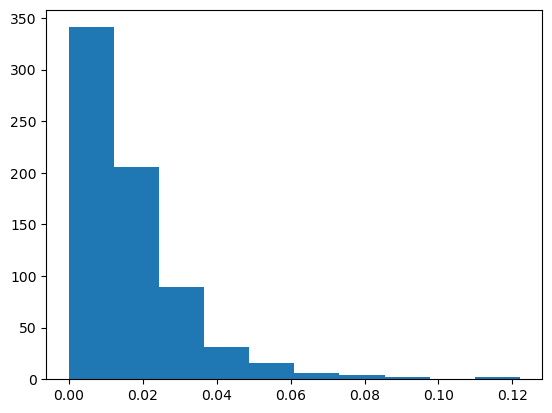

In [78]:
traversal_scores_train = []

for _, score in test_set:
    traversal_scores_train.append(score[0])
    
# print(traversal_scores_train)
plt.hist(traversal_scores_train, bins=10)

In [32]:
print(44*16-697)

7


## Save model parameters

In [ ]:
# Save the model parameters
torch.save(model.state_dict(), "resnet18_fine_tuned.params")